# Assignment 2


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from graphviz import Digraph
import numpy as np
import pandas as pd
import copy as cp
from collections import OrderedDict as odict
from itertools import product, combinations
from tabulate import tabulate

## Representation
### 1. Load from .net file

In [13]:
from assigment2 import GraphicalModel

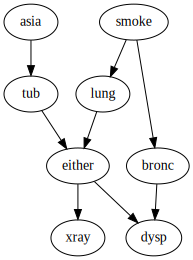

{'asia': ('yes', 'no'),
 'tub': ('yes', 'no'),
 'smoke': ('yes', 'no'),
 'lung': ('yes', 'no'),
 'bronc': ('yes', 'no'),
 'either': ('yes', 'no'),
 'xray': ('yes', 'no'),
 'dysp': ('yes', 'no')}

In [14]:
g = GraphicalModel()
g.load('small/asia.net')
g.showGraph()
g.outcomeSpace

### 2. Insert and remove nodes.

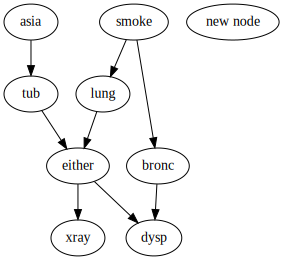

In [8]:
g.insert('new node', ('yes', 'no'))
g.showGraph()

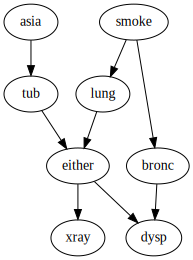

In [9]:
g.remove('new node')
g.showGraph()

### 3. Connect and disconnect nodes with edges.

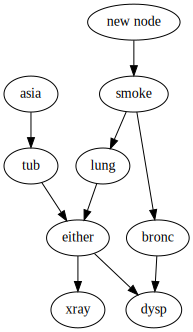

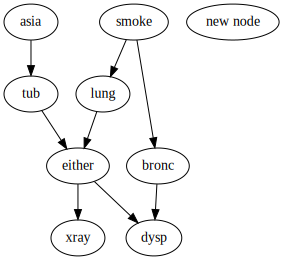

In [15]:
g.insert('new node', ('yes', 'no'))
g.connect('new node', 'smoke')
g.showGraph()
g.disconnect('new node', 'smoke')
g.showGraph()